In [1]:
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

In [3]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [4]:
X = df.iloc[:, 3:-1].values
Y = df.iloc[:, -1].values

In [5]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [6]:
labelEncoder_x_1 = LabelEncoder()
labelEncoder_x_2 = LabelEncoder()

X[:, 1] = labelEncoder_x_1.fit_transform(X[:, 1])  # encoding 'geography' col
X[:, 2] = labelEncoder_x_1.fit_transform(X[:, 2])  # encoding 'gender' col

In [7]:
"""
 very important section 
"""
from sklearn.compose import ColumnTransformer

In [8]:
ct = ColumnTransformer([('Geography', OneHotEncoder(), [1])],remainder='passthrough')
X = ct.fit_transform(X)
X = X[:, 1:]   # avoid dummy variable trap

In [9]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
sc = StandardScaler()

In [12]:
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [13]:
class trainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data  
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__ (self):
        return len(self.X_data)

class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_data = trainData(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
test_data = testData(torch.FloatTensor(x_test))

In [14]:
input_neurons = 11
hidden_neurons = 20
output_neurons = 1
batch_size = 10
epoch = 50
learning_rate = 0.001

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [16]:
from torch import nn

In [17]:
class ANN(nn.Module):
    def __init__(self, input_neuron, hidden_neuron, output_neuron):
        super(ANN, self).__init__()
        
        self.l1 = nn.Linear(input_neuron, hidden_neuron)
        self.l2 = nn.Linear(hidden_neuron, hidden_neuron)
        self.l3 = nn.Linear(hidden_neuron, output_neuron)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(hidden_neurons)
        self.batchnorm2 = nn.BatchNorm1d(hidden_neurons)
    
    def forward(self, inputs):
        x = self.relu(self.l1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.l2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.l3(x)
        
        return x

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
model = ANN(input_neurons, hidden_neurons, output_neurons)
model.to(device)

ANN(
  (l1): Linear(in_features=11, out_features=20, bias=True)
  (l2): Linear(in_features=20, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [20]:
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
def binary_acc(y_pred, y_actual):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_actual).sum().float()
    acc = correct_results_sum / y_actual.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [22]:
model.train()
for e in range(1, epoch+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 1: | Loss: 0.48553 | Acc: 77.800
Epoch 2: | Loss: 0.41362 | Acc: 81.963
Epoch 3: | Loss: 0.39345 | Acc: 83.350
Epoch 4: | Loss: 0.39023 | Acc: 83.300
Epoch 5: | Loss: 0.38051 | Acc: 84.088
Epoch 6: | Loss: 0.37380 | Acc: 84.263
Epoch 7: | Loss: 0.38021 | Acc: 84.037
Epoch 8: | Loss: 0.37636 | Acc: 84.650
Epoch 9: | Loss: 0.37144 | Acc: 84.737
Epoch 10: | Loss: 0.36838 | Acc: 84.838
Epoch 11: | Loss: 0.36884 | Acc: 84.975
Epoch 12: | Loss: 0.36664 | Acc: 84.862
Epoch 13: | Loss: 0.37272 | Acc: 84.650
Epoch 14: | Loss: 0.36631 | Acc: 85.400
Epoch 15: | Loss: 0.36453 | Acc: 84.987
Epoch 16: | Loss: 0.36194 | Acc: 85.138
Epoch 17: | Loss: 0.36533 | Acc: 84.987
Epoch 18: | Loss: 0.36691 | Acc: 85.025
Epoch 19: | Loss: 0.36121 | Acc: 85.350
Epoch 20: | Loss: 0.36596 | Acc: 85.225
Epoch 21: | Loss: 0.36602 | Acc: 84.950
Epoch 22: | Loss: 0.36347 | Acc: 85.138
Epoch 23: | Loss: 0.36041 | Acc: 85.375
Epoch 24: | Loss: 0.35733 | Acc: 85.225
Epoch 25: | Loss: 0.35798 | Acc: 85.338
Epoch 26:

In [23]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

<AxesSubplot:>

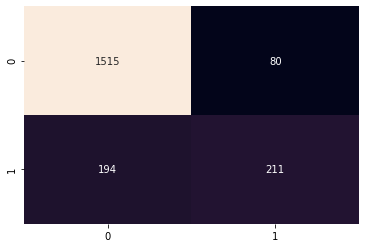

In [25]:
sns.heatmap(confusion_matrix(y_test, y_pred_list), annot=True, fmt='.0f', cbar=False)  

In [26]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1595
           1       0.73      0.52      0.61       405

    accuracy                           0.86      2000
   macro avg       0.81      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [27]:
round(accuracy_score(y_test, y_pred_list)*100, 2)

86.3

In [28]:
# https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89